### download data

In [3]:
!kaggle competitions download -c airbus-ship-detection

 85%|████████████████████████████████▎     | 5.00M/5.87M [00:00<00:00, 9.43MB/s]
100%|██████████████████████████████████████| 5.87M/5.87M [00:00<00:00, 21.5MB/s]
  0%|                                                | 0.00/448K [00:00<?, ?B/s]
100%|████████████████████████████████████████| 448K/448K [00:00<00:00, 29.1MB/s]
 58%|██████████████████████                | 7.00M/12.1M [00:00<00:00, 29.8MB/s]
100%|██████████████████████████████████████| 12.1M/12.1M [00:00<00:00, 40.4MB/s]
100%|█████████████████████████████████████▉| 12.2G/12.2G [03:44<00:00, 60.8MB/s]
100%|██████████████████████████████████████| 12.2G/12.2G [03:44<00:00, 58.1MB/s]
100%|█████████████████████████████████████▉| 14.3G/14.3G [04:25<00:00, 55.3MB/s]
100%|██████████████████████████████████████| 14.3G/14.3G [04:25<00:00, 57.7MB/s]


### begin

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import shutil
import os
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

In [2]:
# %load base_imports
get_ipython().run_line_magic('reload_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
get_ipython().run_line_magic('matplotlib', 'inline')

import sys
import shutil
import os
from pathlib import Path
import numpy as np
import pandas as pd


In [3]:
sys.path.append("../fastai/")
from fastai.conv_learner import *

In [4]:
path = Path("../DATA/airbus-ship/")
files = list(path.iterdir())

In [5]:
files

[PosixPath('../DATA/airbus-ship/train_ship_segmentations.csv'),
 PosixPath('../DATA/airbus-ship/train_all_labels.csv'),
 PosixPath('../DATA/airbus-ship/test_all'),
 PosixPath('../DATA/airbus-ship/train_all_lbs.csv'),
 PosixPath('../DATA/airbus-ship/test_ship_segmentations.csv'),
 PosixPath('../DATA/airbus-ship/e5bcb0727.jpg'),
 PosixPath('../DATA/airbus-ship/models'),
 PosixPath('../DATA/airbus-ship/test_all_lbs.csv'),
 PosixPath('../DATA/airbus-ship/train_all'),
 PosixPath('../DATA/airbus-ship/segmentations'),
 PosixPath('../DATA/airbus-ship/tmp')]

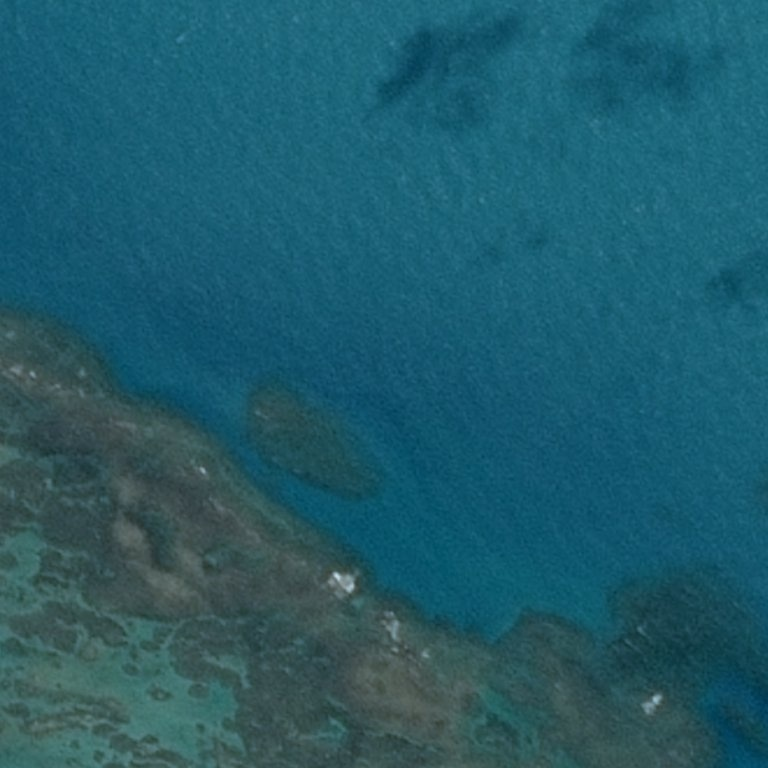

In [6]:
i = np.random.randint(0,len(list((path/'train_all').iterdir())))
Image.open(list((path/'train_all').iterdir())[i])

### Get stats about images

**IMPORTANT NOTE** : DUE TO DATA LEAKAGE TEST SET IS NOW PART OF TRAIN AND NEW TEST SET WILL ARRIVE. https://www.kaggle.com/c/airbus-ship-detection/discussion/64702

In [10]:
train_files = list((path/'train').iterdir())
test_files = list((path/'test').iterdir())

In [12]:
path

PosixPath('../DATA/airbus-ship')

In [17]:
train_segmentations = pd.read_csv(path/'train_ship_segmentations.csv')
test_segmentations = pd.read_csv(path/'test_ship_segmentations.csv')

In [9]:
len(train_files), len(test_files)

(104070, 88500)

In [18]:
# there may be more than one instances per image
train_segmentations.shape, test_segmentations.shape

((131030, 2), (100693, 2))

In [19]:
train_segmentations.ImageId[:10]

0    00003e153.jpg
1    000155de5.jpg
2    00021ddc3.jpg
3    00021ddc3.jpg
4    00021ddc3.jpg
5    00021ddc3.jpg
6    00021ddc3.jpg
7    00021ddc3.jpg
8    00021ddc3.jpg
9    00021ddc3.jpg
Name: ImageId, dtype: object

(768, 768, 3)

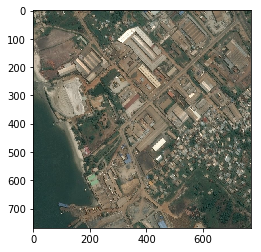

In [26]:
im = open_image(str(path/"train/00021ddc3.jpg"))
plt.imshow(im)
im.shape

In [27]:
# ratio of images without ships
train_segmentations.isna().sum()/train_segmentations.ImageId.nunique()

ImageId          0.000000
EncodedPixels    0.720669
dtype: float64

In [28]:
# ratio of images without ships
test_segmentations.isna().sum()/test_segmentations.ImageId.nunique()

ImageId          0.000000
EncodedPixels    0.847592
dtype: float64

In [29]:
# total number of available training files
len(train_files) + len(test_files)

192570

In [30]:
# add has_ship label
train_segmentations['has_ship'] = train_segmentations.EncodedPixels.apply(lambda x: 0 if pd.isnull(x) else 1)
test_segmentations['has_ship'] = test_segmentations.EncodedPixels.apply(lambda x: 0 if pd.isnull(x) else 1)

In [31]:
train_segmentations.to_csv(path/'train_ship_segmentations.csv', index=False)
test_segmentations.to_csv(path/'test_ship_segmentations.csv', index=False)

In [32]:
train_cls_labels = train_segmentations[['ImageId', 'has_ship']].reset_index(drop=True)
test_cls_labels =  test_segmentations[['ImageId', 'has_ship']].reset_index(drop=True)

In [33]:
train_cls_labels.nunique()

ImageId     104070
has_ship         2
dtype: int64

In [34]:
test_cls_labels.nunique()

ImageId     88486
has_ship        2
dtype: int64

In [35]:
# extra 14 images 
len(np.unique(test_files)) - test_segmentations.ImageId.nunique()

14

In [36]:
# create merged train file
pd.concat([train_cls_labels, test_cls_labels],0).reset_index(drop=True).drop_duplicates().to_csv(path/"train_all_labels.csv", index=False)

In [44]:
# # move train and test(leaked) images to common folder
# os.makedirs(path/"train_all", exist_ok=True)
# # command for size limitation
!find ../DATA/airbus-ship/train/ -type f -maxdepth 1 -name '*' -exec mv -t ../DATA/airbus-ship/train_all/ {} +
!find ../DATA/airbus-ship/test/ -type f -maxdepth 1 -name '*' -exec mv -t ../DATA/airbus-ship/train_all/ {} +

find: warning: you have specified the -maxdepth option after a non-option argument -type, but options are not positional (-maxdepth affects tests specified before it as well as those specified after it).  Please specify options before other arguments.

find: warning: you have specified the -maxdepth option after a non-option argument -type, but options are not positional (-maxdepth affects tests specified before it as well as those specified after it).  Please specify options before other arguments.



In [129]:
train_all_labels = pd.read_csv(path/"train_all_labels.csv")

In [47]:
trn_idx, test_idx = train_test_split(train_all_labels.has_ship, test_size=0.1, stratify=train_all_labels.has_ship, random_state=42)

In [49]:
len(trn_idx), len(test_idx)

(173300, 19256)

In [50]:
np.mean(trn_idx), np.mean(test_idx)

(0.22100403923831505, 0.22102201911092648)

In [51]:
# create test images 10%
os.makedirs(path/'test_all', exist_ok=True)

In [52]:
test_img_fnames = train_all_labels["ImageId"][test_idx.index].values

In [53]:
for fn in test_img_fnames: shutil.move(path/"train_all"/fn, path/"test_all"/fn)

In [54]:
train_all_labels.to_csv(path/"train_all_labels.csv", index=False)

In [130]:
train_all_labels.iloc[trn_idx.index].reset_index(drop=True).to_csv(path/"train_all_lbs.csv", index=False)
train_all_labels.iloc[test_idx.index].reset_index(drop=True).to_csv(path/"test_all_lbs.csv", index=False)

### Visualizing data

In [7]:
import time

# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [8]:
train_segmentations.sort_values('EncodedPixels').head()

NameError: name 'train_segmentations' is not defined

In [ ]:
plt.rcParams['figure.figsize'] = 5,5

In [9]:
ship_imgs = train_segmentations[~train_segmentations.EncodedPixels.isna()]['ImageId'].unique()
img_id = np.random.choice(ship_imgs)
img = open_image(str(path/'train_all'/img_id))
shape = img.shape[:-1]

rles = train_segmentations[train_segmentations.ImageId == img_id]['EncodedPixels']
joined_mask = sum([rle_decode(rle_str, shape) for rle_str in rles.values])

fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img)
axarr[1].imshow(joined_mask)
axarr[2].imshow(img)
axarr[2].imshow(joined_mask, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

NameError: name 'train_segmentations' is not defined

In [10]:
non_ship_imgs = train_segmentations[train_segmentations.EncodedPixels.isna()]['ImageId']

NameError: name 'train_segmentations' is not defined

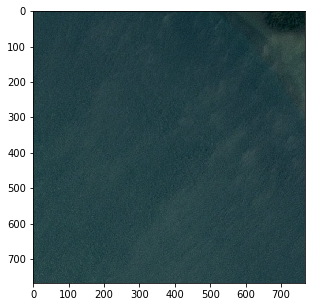

In [65]:
img_id = np.random.choice(non_ship_imgs)
img = open_image(str(path/'train_all'/img_id))
plt.imshow(img)

### idea 1 -  has ship classifier

In [11]:
train_all_labels = pd.read_csv(path/"train_all_lbs.csv")
test_all_labels = pd.read_csv(path/"test_all_lbs.csv")

In [12]:
train_all_labels.shape, test_all_labels.shape

((173300, 2), (19256, 2))

In [13]:
_, val_idx = train_test_split(train_all_labels, test_size=0.1, stratify=train_all_labels.has_ship, random_state=42)
val_idx = (val_idx.index).tolist()

In [14]:
arch = resnet18
sz = 224

In [15]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)

In [16]:
# cv_idxs automatically creates validation set
data = ImageClassifierData.from_csv(path, folder='train_all', bs=128, val_idxs=val_idx,
                                    csv_fname=path/'train_all_lbs.csv', tfms=tfms, test_name="test_all")

In [17]:
len(data.trn_ds), len(data.val_ds), len(data.trn_ds)+len(data.val_ds)

(155970, 17330, 173300)

In [18]:
# number of images without ships : majority prediction
baseline = 1 - np.mean(data.val_ds.y); print(f"baseline acc: {np.round(baseline,4)}")

baseline acc: 0.779


In [19]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [146]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 87%|████████▋ | 1057/1219 [07:46<01:11,  2.27it/s, loss=1.1]  

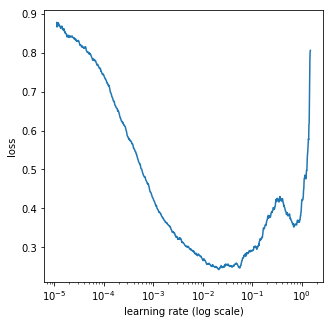

In [147]:
learn.sched.plot()

In [18]:
learn.fit(1e-2, 10, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.215418   0.175501   0.936815  
    1      0.193823   0.164612   0.939527                      
    2      0.196095   0.16301    0.940162                      
    3      0.193763   0.158723   0.941662                      
    4      0.18775    0.157721   0.94322                       
    5      0.183975   0.152994   0.943739                      
    6      0.179724   0.150535   0.944951                      
    7      0.177739   0.149299   0.945759                      
    8      0.175992   0.147078   0.946105                      
    9      0.176934   0.145998   0.946682                      



[array([ 0.146]), 0.9466820542343215]

In [19]:
learn.save("ckpt1")

In [20]:
learn.load("ckpt1")

In [ ]:
learn.fit(1e-2, 5, cycle_len=1)

In [22]:
learn.save("ckpt2")

In [20]:
learn.load("ckpt2")

In [25]:
learn.fit(1e-2, 10, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

  1%|          | 8/1219 [00:06<16:38,  1.21it/s, loss=0.165]  


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



KeyboardInterrupt: 

In [24]:
learn.load("ckpt3")